In [1]:
####Variable order Tensor Decompositionによる業績スコア予測エンジン開発####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import itertools
import scipy
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from datetime import time, datetime, timedelta
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
import re
import MeCab
import neologdn
import sys

np.random.seed(98537)

In [2]:
##データの読み込み
def data_input(iep, flag1, remove_item, remove_element):
    ##データの設定
    #ニュースデータの読み込み
    input_path = "D:/Statistics/data/DJ_news_data/custom_data/DJ_fulldata_new.csv"
    read_data = pd.read_csv(input_path, index_col=0)
    
    #iep要因のみ抽出
    if iep==1:
        index_iep = np.array(np.where(read_data["model"]=="IEP")[0], dtype="int")
        read_data = read_data.iloc[index_iep]
        read_data.index = np.arange(read_data.shape[0])

    #広範に影響を与える要因のレコードのみを除去
    if flag1==1:
        index_item = np.array(~np.in1d(read_data["item"], remove_item), dtype="int")
        index_element = np.array(~np.in1d(read_data["element"], remove_element), dtype="int")
        index = np.array(np.where((index_item+index_element)==2)[0], dtype="int")
        read_data = read_data.iloc[index]
        read_data.index = np.arange(read_data.shape[0])
        
    #広範に影響を与える要因を含むニュースを除去
    if flag1==2:
        index_item = np.array(np.in1d(read_data["item"], remove_item), dtype="int")
        index_element = np.array(np.in1d(read_data["element"], remove_element), dtype="int")   
        index = np.array(np.where((index_item+index_element) > 0)[0], dtype="int")
        key = np.unique(read_data["key"].iloc[index])
        delete_key = pd.merge(read_data[["key"]], pd.DataFrame({"key": key, "no": np.arange(key.shape[0])}), on="key", how="left")
        read_data = read_data.iloc[np.where(pd.isna(delete_key["no"])==True)]
        read_data.index = np.arange(read_data.shape[0])
        
    #カラムの入れ替えとインデックスの定義
    read_data = read_data[["key", "date", "headline", "text", "area", "subject", "item", "element", "predicate", "trend",
                           "tags", "complete", "model", "aiep", "identified"]]
    read_data.index = np.arange(read_data.shape[0])
    

    #株価データの読み込み
    panel_data = pd.read_csv("D:/Statistics/data/stock_price/stock_panel_new.csv")
    company_info = pd.read_csv("D:/Statistics/data/stock_price/st-jp/company_info.csv")
    date_range = [np.min(panel_data["日付"]), np.max(panel_data["日付"])]
    
    #不要な業界を取り除く
    rid_object = np.array(["REIT", "カントリーF", "インフラF"])
    index = ~numpy.in1d(panel_data["業種"], rid_object, assume_unique=False, invert=False)
    panel_data = panel_data.iloc[index]
    return read_data, company_info, panel_data

In [3]:
##データの前処理
def data_preprocess(read_data, company_info, panel_data, gathering):
    ##分析済みのデータのみを取り出す
    index_get = np.array(np.where(np.array(pd.isna(read_data[["aiep"]])==False).reshape(-1))[0], dtype="int")
    df = read_data.iloc[index_get, ]
    df.index = np.arange(df.shape[0])
    del read_data
    
    ##単語の名寄せを行う
    #データの読み込み
    area_dic = pd.read_csv("D:/Statistics/data/dic/area_pattern_freq.csv", encoding="Shift-Jis")
    item_dic = pd.read_csv("D:/Statistics/data/dic/item_pattern_freq.csv", encoding="Shift-Jis")

    #辞書から単語を名寄せ
    if gathering==1:
        tmp_df = df.copy()
        tmp_df = pd.merge(tmp_df, area_dic, left_on="area", right_on="input", how="left")
        tmp_df = pd.merge(tmp_df, item_dic, left_on="item", right_on="input", how="left")
        df["area"] = tmp_df["output2"]; df["item"] = tmp_df["output"]
        del tmp_df
    
    #aiepがすべてnanのニュースを取り除く
    Z = np.zeros((df.shape[0], 5), dtype="int")
    Z[:, 0] = ~pd.isna(df["area"])
    Z[:, 1] = ~pd.isna(df["item"])
    Z[:, 2] = ~pd.isna(df["element"])
    Z[:, 3] = ~pd.isna(df["subject"])
    Z[:, 4] = ~pd.isna(df["trend"])
    df = df.iloc[np.where(np.sum(Z, axis=1) >= 2)[0]]
    df.index = np.arange(df.shape[0])
    
    ##データの設定
    #日付をdatetime型に変更
    df["date"] = pd.to_datetime(df["date"].str[0:19])
    panel_data["日付"] = pd.to_datetime(panel_data["日付"] + " 14:30:00")
    date_range = np.array([np.min(panel_data["日付"][panel_data["日付"] > "2010"]), 
                           np.max(panel_data["日付"][panel_data["日付"] < "2019"])])
    #date_range = np.array([np.min(panel_data["日付"]), np.max(panel_data["日付"])])

    #ニュースのある期間のデータのみ抽出
    index1 = np.array(np.where((panel_data["日付"] > date_range[0]) & (panel_data["日付"] <= date_range[1]))[0], dtype="int")
    index2 = np.array(np.where((df["date"] > date_range[0]) & (df["date"] <= date_range[1]))[0], dtype="int")
    target_panel = panel_data.iloc[index1]
    target_df = df.iloc[index2]
    target_panel.index = np.arange(target_panel.shape[0])
    target_df.index = np.arange(target_df.shape[0])
    del panel_data
    return target_panel, target_df

In [4]:
#aiepの組み合わせの個数をカウントする
def pattern_count():
    area_vec = target_df["area"]; area_vec[pd.isna(area_vec)] = "抽出なし"
    item_vec = target_df["item"]; item_vec[pd.isna(item_vec)] = "抽出なし"
    element_vec = target_df["element"]; element_vec[pd.isna(element_vec)] = "抽出なし"
    subject_vec = target_df["subject"]; subject_vec[pd.isna(subject_vec)] = "抽出なし"
    trend_vec = target_df["trend"]; trend_vec[pd.isna(trend_vec)] = "抽出なし"
    aiep_vec = area_vec + " - " + item_vec + " - " + element_vec + " - " + subject_vec + " - " + trend_vec
    res = aiep_vec.value_counts()
    freq_df = pd.DataFrame({"pattern": np.array(res.index), "freq": np.array(res, dtype="int")})
    freq_df.to_csv("D:/Statistics/data/aiep_pattern_freq.csv", sep=",")
    return freq_df

In [5]:
##ニュースソースを削減する
def delete_news(target_df):
    
    #要因の個数を集計する
    area_count = pd.Series.value_counts(target_df["area"])
    target_area = np.array((area_count[area_count >= 1].index))
    item_count = pd.Series.value_counts(target_df["item"])
    target_item = np.array((item_count[item_count >= 5].index))
    subject_count = pd.Series.value_counts(target_df["subject"])
    target_subject = np.array((subject_count[subject_count >= 1].index))
    element_count = pd.Series.value_counts(target_df["element"])
    target_element = np.array((element_count[element_count >= 5].index))

    #データフレームをサンプルする
    target1 = np.in1d(target_df["area"], target_area) | pd.isna(target_df["area"])
    target2 = np.in1d(target_df["item"], target_item) | pd.isna(target_df["item"])
    target3 = np.in1d(target_df["subject"], target_subject) | pd.isna(target_df["subject"])
    target4 = np.in1d(target_df["element"], target_element) | pd.isna(target_df["element"])
    target_df = target_df.iloc[np.array(target1 & target2 & target3 & target4)]
    target_df.index = np.arange(target_df.shape[0])

    area_count.to_csv("D:/Statistics/data/area_pattern_freq.csv", sep=",")
    item_count.to_csv("D:/Statistics/data/item_pattern_freq.csv", sep=",")
    subject_count.to_csv("D:/Statistics/data/subject_pattern_freq.csv", sep=",")
    element_count.to_csv("D:/Statistics/data/element_pattern_freq.csv", sep=",")
    
    ##aiepに数値idを設定
    #ユニークな要素を抽出
    unique_area = pd.unique(target_df["area"]); area_n = unique_area.shape[0]
    unique_item = pd.unique(target_df["item"]); item_n = unique_item.shape[0]
    unique_subject = pd.unique(target_df["subject"]); subject_n = unique_subject.shape[0]
    unique_element = pd.unique(target_df["element"]); element_n = unique_element.shape[0]
    unique_trend = pd.unique(target_df["trend"]); trend_n = unique_trend.shape[0]
    unique_predicate = pd.unique(target_df["predicate"]); predicate_n = unique_predicate.shape[0]
    unique_tags = pd.unique(target_df["tags"]); tags_n = unique_tags.shape[0]
    type_n = [item_n-1, element_n-1, trend_n-1]

    #マスターデータにidを設定
    area_df = pd.DataFrame({"area": unique_area, "id": np.arange(area_n)})
    area_id = np.array(pd.merge(target_df[["area"]], area_df, on="area", how="left")["id"], dtype="int")

    unique_item = np.append(unique_item[~pd.isna(pd.Series(unique_item))], np.nan)
    item_df = pd.DataFrame({"item": unique_item, "id": np.arange(item_n)})
    item_id = np.array(pd.merge(target_df[["item"]], item_df, on="item", how="left")["id"], dtype="int")

    unique_subject = np.append(unique_subject[~pd.isna(pd.Series(unique_subject))], np.nan)
    subject_df = pd.DataFrame({"subject": unique_subject, "id": np.arange(subject_n)})
    subject_id = np.array(pd.merge(target_df[["subject"]], subject_df, on="subject", how="left")["id"], dtype="int")

    unique_element = np.append(unique_element[~pd.isna(pd.Series(unique_element))], np.nan)
    element_df = pd.DataFrame({"element": unique_element, "id": np.arange(element_n)})
    element_id = np.array(pd.merge(target_df[["element"]], element_df, on="element", how="left")["id"], dtype="int")

    unique_trend = np.append(unique_trend[~pd.isna(pd.Series(unique_trend))], np.nan)
    trend_df = pd.DataFrame({"trend": unique_trend, "id": np.arange(trend_n)})
    trend_id = np.array(pd.merge(target_df[["trend"]], trend_df, on="trend", how="left")["id"], dtype="int")
    return target_df, area_df, area_id, item_df, item_id, subject_df, subject_id, element_df, element_id, trend_df, trend_id

In [6]:
##ニュースデータと株価データを対応付ける
def correspond_data(target_df, target_panel, area_id, item_id, subject_id, element_id, trend_id):
    #ニュースデータの日付を市場が開いている時間に繰り越す
    index = np.array(np.where((target_df["date"].apply(lambda x:x.time()) >= time(hour=0)) & 
                              (target_df["date"].apply(lambda x:x.time()) <= time(hour=15)))[0], dtype="int")
    index_target = np.delete(np.arange(target_df.shape[0]), index)
    new_date = target_df[["date"]].copy()
    new_date["date"].iloc[index_target] = target_df["date"].iloc[index_target] + timedelta(days=1)

    #日付のデータ型を数値型に変更
    df_date = np.array((new_date["date"].dt.date.astype("str")).str.replace("-", ""), dtype="int")
    panel_date = np.array(target_panel["日付"].dt.date.astype("str").str.replace("-", ""), dtype="int")
    unique_date = np.array(np.sort(np.unique(df_date)), dtype="int")  
    date_n = unique_date.shape[0]

    #重複しているニュースを特定
    tmp_df = pd.concat((pd.DataFrame(df_date), target_df[["area", "subject", "item", "element", "trend"]]), axis=1)
    tmp_df = tmp_df.rename(columns={0: "date"})
    tmp_df = tmp_df.fillna("hoge")
    index_dup = np.array(tmp_df.duplicated())
    joint_tag = tmp_df["date"].astype("U8") + "-" + tmp_df["area"] + "-" + tmp_df["subject"] +\
                    "- " + tmp_df["item"] + "-" + tmp_df["element"] + "-" + tmp_df["trend"]
    joint_count = joint_tag.value_counts()
    pd.DataFrame({"tag": joint_count.index, "freq": np.array(joint_count, dtype="int")}).to_csv("D:/Statistics/data/record_dup.csv")

    #重複を削除
    target_df = target_df.iloc[~index_dup, ]
    target_df.index = np.arange(target_df.shape[0])
    area_id = area_id[~index_dup]
    item_id = item_id[~index_dup]
    subject_id = subject_id[~index_dup]
    element_id = element_id[~index_dup]
    trend_id = trend_id[~index_dup]
    df_date = df_date[~index_dup]

    #日付ごとにニュースと株価を対応付ける
    df_index = [j for j in range(date_n)]
    panel_index = [j for j in range(date_n)]

    for j in range(date_n):
        df_index[j] = np.array(np.where(df_date==unique_date[j])[0], dtype="int")
        index = np.array(np.where(panel_date==unique_date[j])[0], dtype="int")
        rp = 0
        if index.shape[0]==0:
            while True:
                rp = rp + 1
                if j + rp >= date_n:
                    break
                index = np.array(np.where(panel_date==unique_date[j+rp])[0], dtype="int")
                if index.shape[0] > 0:
                    break
        panel_index[j] = index

    #日付ごとに要素数を数える
    panel_n = np.repeat(0, date_n)
    df_n = np.repeat(0, date_n)
    for j in range(date_n):
        panel_n[j] = panel_index[j].shape[0]
        if panel_n[j] > 0:
            df_n[j] = df_index[j].shape[0]
    return target_df, area_id, item_id, subject_id, element_id, trend_id, df_date

In [7]:
##インデックスを設定
def create_index(area_id, item_id, subject_id, element_id, trend_id):
    #アイテムごとのユニーク数を数える
    area_n = np.unique(area_id).shape[0]
    item_n = np.unique(item_id).shape[0]
    subject_n = np.unique(subject_id).shape[0]
    element_n = np.unique(element_id).shape[0]
    trend_n = np.unique(trend_id).shape[0]
    
    #インデックスを定義
    index_area = [i for i in range(area_n)]
    index_item = [i for i in range(item_n)]
    index_subject = [i for i in range(subject_n)]
    index_element = [i for i in range(element_n)]
    index_trend = [i for i in range(trend_n)]
    for i in range(area_n):
        index_area[i] = np.array(np.where(area_id==i)[0], dtype="int")
    for i in range(item_n):
        index_item[i] = np.array(np.where(item_id==i)[0], dtype="int")
    for i in range(subject_n):
        index_subject[i] = np.array(np.where(subject_id==i)[0], dtype="int")
    for i in range(element_n):
        index_element[i] = np.array(np.where(element_id==i)[0], dtype="int")
    for i in range(trend_n):
        index_trend[i] = np.array(np.where(trend_id==i)[0], dtype="int")
    return index_area, index_item, index_subject, index_element, index_trend

In [8]:
def create_response_variable(target_panel):
    ##応答変数を加工
    #データの設定
    price = np.array(target_panel["調整後終値"])
    code = np.array(target_panel["コード"], dtype="int")
    reference_id = np.array(target_panel["reference_id"], dtype="int")
    N = target_panel.shape[0]
    
    #新しいreference_idを設定
    target_company_info = company_info.iloc[np.in1d(company_info["reference_id"], np.unique(reference_id))]
    target_company_info.index = np.arange(target_company_info.shape[0])
    target_company_info = pd.concat((target_company_info, pd.DataFrame(np.arange(target_company_info.shape[0]))), axis=1)
    target_company_info = target_company_info[["reference_id", 0, "コード", "銘柄名", "取引市場", "業種", "資本金", "単元株数"]]
    target_company_info.columns = ["reference_id", "new_id", "コード", "銘柄名", "取引市場", "業種", "資本金", "単元株数"]
    
    #panel_dataのreference_idに新しいreference_idを設定
    reference_df = pd.DataFrame(reference_id)
    reference_df.columns = ["reference_id"]
    new_id = np.array(pd.merge(reference_df, target_company_info[["reference_id", "new_id"]], on="reference_id", how="left")["new_id"])
    n = np.unique(new_id).shape[0]

    #panelに新しいreference_idを結合
    target_panel = pd.concat((target_panel, pd.DataFrame(new_id)), axis=1)
    target_panel = target_panel[["reference_id", 0, "コード", "銘柄名", "業種", "日付", "調整後終値", "出来高"]]
    target_panel.columns = ["reference_id", "new_id", "コード", "銘柄名", "業種", "日付", "調整後終値", "出来高"]
    
    #インデックスを作成
    c_index_list = [i for i in range(n)]
    c_no_list = [i for i in range(n)]
    c_max_index = np.repeat(0, n)
    for i in range(n):
        c_index_list[i] = np.array(np.where(new_id==i)[0], dtype="int")
        c_no_list[i] = np.arange(c_index_list[i].shape[0])
        c_max_index[i] = np.max(c_index_list[i])

    #リストを変換
    c_no = np.array(list(itertools.chain(*[np.array(c_no_list[i]) for i in range(n)])))
    
    ##株価の終値の変動率を算出
    #差分を算出するためのインデックス
    index_t1 = np.where(c_no==0)[0]
    index_previous = np.array(np.delete(np.arange(N), c_max_index), dtype="int")
    index_behind = np.array(np.delete(np.arange(N), index_t1), dtype="int")

    #変化率を取得
    diff_ratio = np.repeat(0.0, N)
    diff_price = np.repeat(0.0, N)
    diff_ratio[index_behind] = (price[index_behind] - price[index_previous]) / price[index_previous]
    diff_price[index_behind] = price[index_behind] - price[index_previous]
    
    #階差の移動平均を取る
    n = len(c_index_list)
    moving_average_list = [i for i in range(n)] 
    z_list = [i for i in range(n)]
    long = np.zeros((n, 2))

    for i in range(n):
        index = c_index_list[i]
        num = 5   #移動平均の個数
        b = np.ones(num) / num
        mu = np.convolve(diff_ratio[index], b, mode="same")   #移動平均
        if index.shape[0] < 5:
            moving_average_list[i] = mu[0:index.shape[0]]
            z_list[i] = np.repeat(0, index.shape[0])
        else:
            moving_average_list[i] = mu
            z_list[i] = np.append(np.repeat(0, mu[0:4].shape[0]), np.repeat(1, mu[4:].shape[0]))
        long[i, ] = np.array([index.shape[0], mu.shape[0]])
        
    #リストを変換
    moving_average = np.array(list(itertools.chain(*[np.array(moving_average_list[i]) for i in range(n)])))
    z = np.array(list(itertools.chain(*[np.array(z_list[i]) for i in range(n)])))
    
    #データフレームに変換
    panel_df = pd.concat([target_panel[["reference_id", "new_id", "コード", "銘柄名", "業種", "日付", "調整後終値", "出来高"]],
                          pd.DataFrame({"diff_ratio": diff_ratio, "diff_price": diff_price, "moving_mu": moving_average,
                                       "z": z})], axis=1)
    new_df = panel_df.iloc[index_behind]
    out = "D:/Statistics/data/stock_price/stock_price_diff.csv"
    #panel_df.to_csv(out, sep=",", index=False)
    return panel_df, new_df

In [9]:
##入力変数の前処理
#データの読み込み
remove_item = np.array(["原油", "石油", "米国債", "米ドル", "ユーロ", "日本円", "日本国債", "株式"])
remove_element = np.array(["政策金利", "金利", "株式市場", "米国株", "株価", "利回り", "経済"])
read_data, company_info, panel_data = data_input(1, 1, remove_item, remove_element)

C:\statistics\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\statistics\anaconda\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
#データの加工とデータの絞り込み
target_panel, target_df = data_preprocess(read_data, company_info, panel_data, 0)
res_delete_news = delete_news(target_df)
target_df, area_df, area_id, item_df, item_id, subject_df, subject_id, element_df, element_id, trend_df, trend_id = res_delete_news
del res_delete_news

#株価データとニュースデータを対応付ける
res_correspond_data = correspond_data(target_df, target_panel, area_id, item_id, subject_id, element_id, trend_id)
target_df, area_id, item_id, subject_id, element_id, trend_id, df_date = res_correspond_data
del res_correspond_data
index_area, index_item, index_subject, index_element, index_trend = create_index(area_id, item_id, subject_id, element_id, trend_id)

Text(0.5, 1.0, '企業毎の株価変化率の標準偏差分布')

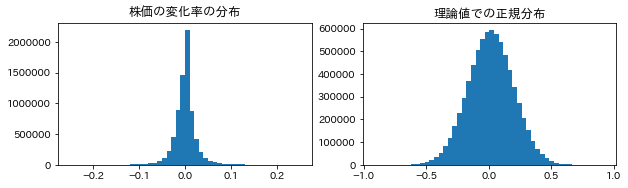

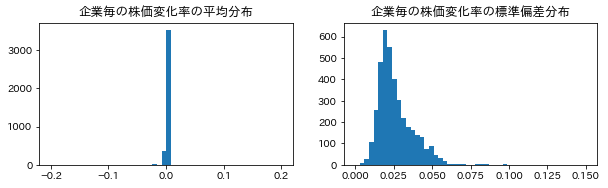

In [11]:
##応答変数の前処理
#応答変数の差分や移動平均を取る
panel_df, new_df = create_response_variable(target_panel)

##分布を可視化
#株価の変化率を可視化
N = panel_df.shape[0]
y = np.array(panel_df["diff_ratio"])
mu = np.mean(np.abs(y))
sd = np.std(np.abs(y)) 
fig = plt.figure(figsize=(10.0, 6.0))
plt.subplots_adjust(wspace=0.2, hspace=0.3)   #余白を設定
ax = fig.add_subplot(2, 2, 1)
ax.hist(y, range=(-0.25, 0.25), bins=50)   #変化率のヒストグラム
plt.title("株価の変化率の分布", fontsize=12.5)
ax = fig.add_subplot(2, 2, 2)
ax.hist(np.random.normal(mu, sd, N), bins=50)
plt.title("理論値での正規分布", fontsize=12.5)

#グループごとの集計値の可視化
N1 = new_df.shape[0]
new_df.index = np.arange(N1)
grouped = new_df.groupby("銘柄名")

#企業毎の集計値をヒストグラムにする
fig = plt.figure(figsize=(10.0, 6.0))
plt.subplots_adjust(wspace=0.2, hspace=0.3)   #余白を設定
ax = fig.add_subplot(2, 2, 1)
ax.hist(np.array(grouped[["diff_ratio"]].mean()).reshape(-1), range=(-0.2, 0.2), bins=50)
plt.title("企業毎の株価変化率の平均分布", fontsize=12.5)
ax = fig.add_subplot(2, 2, 2)
ax.hist(np.array(grouped[["diff_ratio"]].std()).reshape(-1), range=(0, 0.15), bins=50)
plt.title("企業毎の株価変化率の標準偏差分布", fontsize=12.5)

In [12]:
del target_panel

In [13]:
####aiepのid配置を割り当て####
##ニュースソースのaiepをグループごとにデータフレームに格納
#日付の連番idを作成
unique_date = np.unique(df_date); date_n = unique_date.shape[0]
co_date = pd.DataFrame(df_date); co_date.columns = ["date"]
date_table = pd.DataFrame({"date": unique_date, "id": np.arange(date_n)})
date_id = pd.merge(co_date, date_table, on="date", how="left")

In [14]:
#パネルの日付をint型に変換
tmp_date = new_df["日付"].astype("str")
tmp_date = tmp_date.str[0:10].str.replace("-", "").astype("int")
new_date = pd.merge(pd.DataFrame({"date": tmp_date, "ticker": new_df["コード"]}), date_table, on="date", how="left")
index_date = np.array(np.where(~pd.isna(new_date["date"]))[0], dtype="int")
new_date = new_date.iloc[index_date]
new_panel = new_df.iloc[index_date]
new_date["date"] = np.array(new_date["date"], dtype="int")
new_date["id"] = np.array(new_date["id"], dtype="int")
new_date["ticker"] = np.array(new_date["ticker"], dtype="int")
new_date = new_date[["date", "id", "ticker"]]
new_date.index = np.arange(new_date.shape[0]); new_panel.index = np.arange(new_panel.shape[0])
del new_df

In [15]:
##aiepのidをすべて結合したデータフレームを作成
#結合idを定義
area_dt = pd.DataFrame({"id": area_id})
area_dt = pd.merge(area_dt, area_df, on="id", how="left")
item_dt = pd.DataFrame({"id": item_id})
item_dt = pd.merge(item_dt, item_df, on="id", how="left")
element_dt = pd.DataFrame({"id": element_id})
element_dt = pd.merge(element_dt, element_df, on="id", how="left")
subject_dt = pd.DataFrame({"id": subject_id})
subject_dt = pd.merge(subject_dt, subject_df, on="id", how="left")
trend_dt = pd.DataFrame({"id": trend_id})
trend_dt = pd.merge(trend_dt, trend_df, on="id", how="left")
area_dt.columns = ["area_id", "area"]
item_dt.columns = ["item_id", "item"]
element_dt.columns = ["element_id", "element"]
subject_dt.columns = ["subject_id", "subject"]
trend_dt.columns = ["trend_id", "trend"]

In [16]:
#資本金の多い上位500社を抽出
n = 500
target_company = company_info.sort_values(by=["資本金"], ascending=False).iloc[:n]
target_company.index = np.arange(target_company.shape[0])
target_company = pd.concat((target_company, pd.DataFrame(np.arange(target_company.shape[0]))), axis=1)
target_company = target_company.rename(columns={0: "id"})
index_target = np.array(np.where((np.in1d(new_panel["コード"], target_company["コード"])==True) &
                                 (new_panel["diff_ratio"] > -0.5) & (new_panel["diff_ratio"] < 1.0))[0], dtype="int")
target_date = new_date.iloc[index_target]
target_date.index = np.arange(target_date.shape[0])
target_panel = new_panel.iloc[index_target]
target_panel.index = np.arange(target_panel.shape[0])
target_panel = pd.merge(target_panel, target_company[["コード", "id"]], 
                        on="コード", how="left")[["id", "コード", "銘柄名", "業種",
                                               "日付", "調整後終値", "出来高", "diff_ratio", "diff_price"]]
target_date = new_date.iloc[index_target]
target_date.index = np.arange(target_date.shape[0])
N = target_panel.shape[0]

In [17]:
####企業毎にaiepのidを割り当てる####
##シナリオの読み込みとクレンジング
#データの読み込み
company = pd.read_csv("D:/Statistics/data/scenario/company.csv")
scenario1 = pd.read_csv("D:/Statistics/data/scenario/level1_scenario.csv")
scenario2 = pd.read_csv("D:/Statistics/data/scenario/level2_scenario.csv")
factor = pd.read_csv("D:/Statistics/data/scenario/Factor.csv")

#読み込んだデータをクレンジング
scenario1.columns = (scenario1.columns).str.replace(" ", "")
scenario2.columns = (scenario2.columns).str.replace(" ", "")
factor.columns = (factor.columns).str.replace(" ", "")
company.columns = (company.columns).str.replace(" ", "")
columns1 = np.array(scenario1.columns)
columns2 = np.array(scenario2.columns)
columns3 = np.array(factor.columns)
columns4 = np.array(company.columns)
for j in range(columns1.shape[0]):
    scenario1[columns1[j]] = scenario1[columns1[j]].str.replace("\"| ", "")
for j in range(columns2.shape[0]):
    scenario2[columns2[j]] = scenario2[columns2[j]].str.replace("\"| ", "")
for j in range(columns3.shape[0]):
    factor[columns3[j]] = factor[columns3[j]].str.replace("\"| ", "")
for j in range(columns4.shape[0]-1):
    company[columns4[j]] = company[columns4[j]].str.replace("\"| ", "")
scenario1["c.name"] = pd.merge(scenario1[["c.ticker"]], company, on="c.ticker", how="left")["c.name"]
scenario2["c.name"] = pd.merge(scenario2[["c.ticker"]], company, on="c.ticker", how="left")["c.name"]
scenario1["c.ticker"] = np.array(scenario1["c.ticker"], dtype="int")
scenario2["c.ticker"] = np.array(scenario2["c.ticker"], dtype="int")
company["c.ticker"] = np.array(company["c.ticker"], dtype="int")

#シナリオを結合
s1 = scenario1[["f.item", "f.element", "f.trend", "c.name", "c.ticker"]]
s2 = scenario2[["f1.item", "f1.element", "f1.trend", "c.name", "c.ticker"]]
s2.columns = ["f.item", "f.element", "f.trend", "c.name", "c.ticker"]
s3 = scenario2[["f2.item", "f2.element", "f2.trend", "c.name", "c.ticker"]]
s3.columns = ["f.item", "f.element", "f.trend", "c.name", "c.ticker"]
scenario = pd.concat((s1, s2, s3), axis=0); scenario.index = np.arange(scenario.shape[0])
scenario = scenario.iloc[np.where(scenario.duplicated()==False)[0]]; scenario.index = np.arange(scenario.shape[0])
del s1, s2, s3

In [19]:
#ニュースデータのアイテムとエレメントを抽出
max_columns = 50
item = np.array(target_df["item"])
element = np.array(target_df["element"])
ticker = np.array(pd.unique(target_panel["コード"]), dtype="int")   #証券コード

#要因の格納用配列
item_box = np.zeros((N, max_columns), dtype="object"); item_box[:,:] = np.nan
element_box = np.zeros((N, max_columns), dtype="object"); element_box[:,:] = np.nan
trend_box = np.zeros((N, max_columns), dtype="object"); trend_box[:,:] = np.nan

In [20]:
##企業毎に要因を日付で紐付ける
for i in range(ticker.shape[0]):
    #企業を抽出
    get_ticker = np.array(np.where(target_date["ticker"]==ticker[i])[0], dtype="int")
    index = np.array(np.where(scenario["c.ticker"]==ticker[i])[0], dtype="int")
    out = scenario.iloc[index]
    if index.shape[0]==0:
        continue
    print(np.array(scenario["c.name"].iloc[index[0]]))

    #企業と要因を紐付ける
    target_item = np.unique(out["f.item"])[1:]
    target_element = np.unique(out["f.element"])[1:]
    index1 = np.array(np.in1d(item, target_item), dtype="int")
    index2 = np.array(np.in1d(element, target_element), dtype="int")
    index = np.array(np.where((index1 + index2)==2)[0], dtype="int")

    #対象の要因を抽出
    item0 = np.array(target_df["item"].iloc[index])
    element0 = np.array(target_df["element"].iloc[index])
    trend0 = np.array(target_df["trend"].iloc[index])
    date0 = np.array(date_id["date"].iloc[index])
    unique_date0 = pd.unique(date0)
    d = unique_date0.shape[0]

    #パネルデータに要因を代入
    for j in range(d):
        index_date = np.array(np.where(date0==unique_date0[j])[0], dtype="int")
        index_sub = get_ticker[np.array(np.where(target_date["date"].iloc[get_ticker]==unique_date0[j])[0], dtype="int")]
        if index_sub.shape[0]==0:
            continue
        trend0_get = np.array(trend0[index_date]); trend0_get[pd.isna(trend0_get)] = "ナシ"
        index_unique = np.array(np.where(pd.Series(item0[index_date] + element0[index_date]
                                                   + trend0_get).duplicated()==False)[0], dtype="int")
        item_box[index_sub, np.arange(index_unique.shape[0])] = item0[index_date[index_unique]] 
        element_box[index_sub, np.arange(index_unique.shape[0])] = element0[index_date[index_unique]] 
        trend_box[index_sub, np.arange(index_unique.shape[0])] = trend0[index_date[index_unique]]

日本水産
マルハニチロ
国際石油開発帝石
大成建
清水建
長谷工
鹿島
西松建
奥村組
東亜建設工業
五洋建設
住友林業
大和ハウス工業
積水ハウス
きんでん
日揮
森永製菓
ヤクルト
明治ＨＤ
雪印メグミルク
日ハム
伊藤ハム米久ホールディングス
いちご
サッポロホールディングス
アサヒグループホールディ
キリンホールディングス
サントリーＢＦ
伊藤園
ローソン
双日
ニチレイ
日清食ＨＤ
日本たばこ産業
グンゼ
ヒューリック
ビックカメラ
J.フロントリテイリング
マツモトキヨシ
東洋紡
日清紡ホールディングス
倉敷紡績
日東紡績
野村不動産ホールディングス
ユニゾホールディングス
東急不ＨＤ
帝人
東レ
クラレ
旭化成
SUMCO
王子ＨＤ
日本製紙
三菱製紙
北越コーポレーション
中越パルプ工業
大王製紙
LINE
レンゴー
昭和電工
住友化学
日産化
石原産業
日本曹達
東ソー
東亞合
デンカ
イビデン
信越化学工業
堺化学
エア・ウォーター
大陽日酸
日触媒
カネカ
協和キリン
菱瓦斯化
三井化学
ＪＳＲ
三菱ケミカルホールディングス
ダイセル
住友ベーク
積水化学工業
日ゼオン
宇部興産
野村総合研究所
ケネディクス
電通
ＡＤＥＫＡ
花王
武田薬
アステラス製薬
大日本住友製薬
科研製薬
エーザイ
日医工
キッセイ薬品工業
沢井製薬
大塚ホールディングス
大正薬ＨＤ
日ペイントＨＤ
関西ペイント
ＤＩＣ
洋インキＨＤ
フジＨＤ
ラウンドワン
リゾートトラスト
オービック
日本オラクル
ユー・エス・エス
伊藤忠テクノソリューションズ
楽天
富士フイルムホールディングス
コニカミノルタ
資生堂
ライオン
昭和シェル石油
富士石油
出光興産
ＪＸＴＧホールディングス
コスモエネルギーホール
横浜ゴム
東洋ゴム工業
ブリヂストン
住友ゴム工業
AGC
日本板硝子
日本電気硝子
住友大阪
太平洋セメ
東海カーボン
TOTO
日本ガイシ
日特殊陶
新日鉄住金
神戸鋼
中山鋼
合同鉄
ＪＦＥ
日新製鋼
東京製鐵
共英製鋼
淀川製鋼所
大同特殊鋼
日本冶金工業
山陽特殊製鋼
愛知製鋼
日立金属
日本製鋼所
日本軽金属ホールディングス
三井金属鉱業
三菱マテリアル
住友鉱
DOWAホールディングス
古河機械金属
ＵＡＣＪ
古河電気工業
住友電気工業
フジクラ
昭和電線

In [21]:
##抽出した要因をクレンジング
#企業と要因が紐付いたレコードのインデックスを作成
target1 = np.array(~pd.isna(item_box), dtype="int8")
target2 = np.array(~pd.isna(element_box), dtype="int8")
target3 = np.array(~pd.isna(trend_box), dtype="int8")
target = np.array(target1+target2+target3 > 0, dtype="int8")
index_target = np.array(np.where(np.sum(target, axis=1) > 0)[0], dtype="int")
max_col = np.max(np.sum(target, axis=1))
del target1, target2, target3

In [22]:
#要因がないカラムを削除
target = target[:, np.arange(max_col)]
item_box = item_box[:, np.arange(max_col)]
element_box = element_box[:, np.arange(max_col)]
trend_box = trend_box[:, np.arange(max_col)]

In [23]:
#抽出した要因を出力
index_get = np.where(np.sum(pd.isna(item_box)==False, axis=1) > 0)[0]
box1 = item_box[index_get, ]; box2 = element_box[index_get, ]; box3 = trend_box[index_get, ]
box1[pd.isna(box1)] = ""; box2[pd.isna(box2)] = ""; box3[pd.isna(box3)] = ""
box = box1 + " - " + box2 + " - " + box3
box[box==" -  - "] = ""
new_df = target_panel[["コード", "銘柄名", "日付", "調整後終値", "diff_ratio"]].iloc[index_get]
new_df.index = np.arange(new_df.shape[0])
factor_df = pd.concat((new_df, pd.DataFrame(box)), axis=1)
factor_df.to_csv("D:/Statistics/data/panel_factor_data.csv", encoding="Shift-Jis")
del new_df, box, box1, box2, box3

In [24]:
##学習データとテストデータに分割
#学習データとテストデータのインデックス
N = target_panel.shape[0]
index_learn = np.random.choice(N, int(4/5 * N), replace=False)
index_test = np.delete(np.arange(N), index_learn)
N1 = index_learn.shape[0]
N2 = index_test.shape[0]

#学習用データに分割
target_panel1 = target_panel.iloc[index_learn]
target_date1 = target_date.iloc[index_learn]
target_panel1.index = np.arange(N1); target_date1.index = np.arange(N1)
target1 = target[index_learn, ]
item_box1 = item_box[index_learn, ]
element_box1 = element_box[index_learn, ]
trend_box1 = trend_box[index_learn, ]

#テスト用データに分割
target_panel2 = target_panel.iloc[index_test]
target_date2 = target_date.iloc[index_test]
target_panel2.index = np.arange(N2); target_date2.index = np.arange(N2)
target2 = target[index_test, ]
item_box2 = item_box[index_test, ]
element_box2 = element_box[index_test, ]
trend_box2 = trend_box[index_test, ]

In [25]:
#要因のあるレコードのインデックスを作成
news_index1 = [j for j in range(max_col)]; news_index2 = [j for j in range(max_col)]
news_n1 = np.repeat(0, max_col); news_n2 = np.repeat(0, max_col)
for j in range(max_col):
    news_index1[j] = np.array(np.where(target1[:, j] > 0)[0], dtype="int")
    news_index2[j] = np.array(np.where(target2[:, j] > 0)[0], dtype="int")
    news_n1[j] = news_index1[j].shape[0]
    news_n2[j] = news_index2[j].shape[0]

In [26]:
##新しい要因のidを作成
#ユニークな要因を抽出
unique_item = np.append(pd.unique(item_box.T.reshape(-1))[1:], np.nan)
unique_item = pd.DataFrame({"item": unique_item, "id": np.arange(unique_item.shape[0])})
unique_element = np.append(pd.unique(element_box.T.reshape(-1))[1:], np.nan)
unique_element = pd.DataFrame({"element": unique_element, "id": np.arange(unique_element.shape[0])})
unique_trend = np.append(pd.unique(trend_box.T.reshape(-1))[1:], np.nan)
unique_trend = pd.DataFrame({"trend": unique_trend, "id": np.arange(unique_trend.shape[0])})
item_n = unique_item.shape[0]
element_n = unique_element.shape[0]
trend_n = unique_trend.shape[0]

#学習用データの新しい要因idを作成
item_id1 = [j for j in range(max_col)]; item_entity1 = [j for j in range(max_col)]
element_id1 = [j for j in range(max_col)]; element_entity1 = [j for j in range(max_col)]
trend_id1 = [j for j in range(max_col)]; trend_entity1 = [j for j in range(max_col)]
for j in range(max_col):
    temp_index = news_index1[j]
    temp_item = pd.merge(pd.DataFrame({"item": item_box1[temp_index, j]}), unique_item, on="item", how="left")
    temp_element = pd.merge(pd.DataFrame({"element": element_box1[temp_index, j]}), unique_element, on="element", how="left")
    temp_trend = pd.merge(pd.DataFrame({"trend": trend_box1[temp_index, j]}), unique_trend, on="trend", how="left")
    item_id1[j] = np.array(temp_item["id"]); item_entity1[j] = np.array(temp_item["item"])
    element_id1[j] = np.array(temp_element["id"]); element_entity1[j] = np.array(temp_element["element"])
    trend_id1[j] = np.array(temp_trend["id"]); trend_entity1[j] = np.array(temp_trend["trend"])
    
#テストデータの新しい要因idを作成
item_id2 = [j for j in range(max_col)]; item_entity2 = [j for j in range(max_col)]
element_id2 = [j for j in range(max_col)]; element_entity2 = [j for j in range(max_col)]
trend_id2 = [j for j in range(max_col)]; trend_entity2 = [j for j in range(max_col)]
for j in range(max_col):
    temp_index = news_index2[j]
    temp_item = pd.merge(pd.DataFrame({"item": item_box2[temp_index, j]}), unique_item, on="item", how="left")
    temp_element = pd.merge(pd.DataFrame({"element": element_box2[temp_index, j]}), unique_element, on="element", how="left")
    temp_trend = pd.merge(pd.DataFrame({"trend": trend_box2[temp_index, j]}), unique_trend, on="trend", how="left")
    item_id2[j] = np.array(temp_item["id"]); item_entity2[j] = np.array(temp_item["item"])
    element_id2[j] = np.array(temp_element["id"]); element_entity2[j] = np.array(temp_element["element"])
    trend_id2[j] = np.array(temp_trend["id"]); trend_entity2[j] = np.array(temp_trend["trend"])
del target, item_box, element_box, trend_box
del target1, item_box1, element_box1, trend_box1
del target2, item_box2, element_box2, trend_box2

In [27]:
#要因を配列として割り当てる
item_dt = np.full((N1, max_col), item_n-1, dtype="int16")
element_dt = np.full((N1, max_col), element_n-1, dtype="int16")
trend_dt = np.full((N1, max_col), trend_n-1, dtype="int16")
for j in range(max_col):
    index = news_index1[j]
    item_dt[index, j] = item_id1[j]
    element_dt[index, j] = element_id1[j]
    trend_dt[index, j] = trend_id1[j]    

In [28]:
##学習データとテストデータのインデックス
#ランダムサンプリングの実行
N = target_panel.shape[0]
index_learn = np.random.choice(N, int(4/5 * N), replace=False)
index_test = np.delete(np.arange(N), index_learn)
N1 = index_learn.shape[0]
N2 = index_test.shape[0]

#データを分割
target_panel1 = target_panel.iloc[index_learn]
target_date1 = target_date.iloc[index_learn]
target_panel1.index = np.arange(N1); target_date1.index = np.arange(N1)
target_panel2 = target_panel.iloc[index_test]
target_date2 = target_date.iloc[index_test]
target_panel2.index = np.arange(N2); target_date2.index = np.arange(N2)

In [29]:
##企業idとインデックスの作成
#企業idを作成
company_id1 = np.array(target_panel1["id"], dtype="int16")
company_id2 = np.array(target_panel2["id"], dtype="int16")

#インデックスを作成
company_index1 = [i for i in range(n)]
company_index2 = [i for i in range(n)]
for i in range(n):
    company_index1[i] = np.array(np.where(company_id1==i)[0], dtype="int")
    company_index2[i] = np.array(np.where(company_id2==i)[0], dtype="int")

In [30]:
####マーケットデータの加工と結合####
##海外指標のデータを加工
#topixの読み込みと加工(dateの基準)
index_ETF = np.where(new_panel["銘柄名"]=="ETF-TOPIX")[0]
ETF = new_panel.iloc[index_ETF]
ETF_date = new_date.iloc[index_ETF]; ETF_date.index = np.arange(ETF_date.shape[0])
ETF_price = pd.DataFrame({"date": ETF_date["date"], "ETF_price": np.array(ETF["調整後終値"]), 
                          "ETF_diff": np.array(ETF["diff_ratio"]) * 100})

#FFレートの読み込みと加工
input_path = "D:/Statistics/data/market_data/fed_fund_rate.csv"
fed_fund_rate = pd.read_csv(input_path, encoding="SHIFT-JIS")
ff_rate = np.array(fed_fund_rate["value"])
ff_diff = np.append(0, ff_rate[1:] - ff_rate[0:ff_rate.shape[0]-1]) 
ff = pd.concat((fed_fund_rate["date"], pd.DataFrame({"ff_rate": ff_rate, "ff_diff": ff_diff})), axis=1)

#米国国債金利の読み込みと加工
input_path = "D:/Statistics/data/market_data/us_interest_rate.csv"
us_interest_rate = pd.read_csv(input_path, encoding="SHIFT-JIS")
us_interest_rate = us_interest_rate.iloc[np.where(~pd.isna(us_interest_rate["RIFLGFCY10_N.B"]))[0]]
us_interest_rate.index = np.arange(us_interest_rate.shape[0])
us_rate = np.array(us_interest_rate["RIFLGFCY10_N.B"])
us_diff = np.append(0, us_rate[1:] - us_rate[0:us_rate.shape[0]-1]) 
us_interest = pd.concat((us_interest_rate["date"], pd.DataFrame({"us_rate": us_rate, "us_diff": us_diff})), axis=1)

#ダウ平均株価の読み込みと加工
input_path = "D:/Statistics/data/market_data/dj_price.csv"
dow_jones_price = pd.read_csv(input_path, encoding="SHIFT-JIS") 
dj_price = np.array(dow_jones_price["Close"])
dj_diff = np.append(0, (dj_price[1:] - dj_price[0:dj_price.shape[0]-1]) / dj_price[0:dj_price.shape[0]-1]) * 100
dow_jones = pd.concat((dow_jones_price[["date"]], 
                       pd.DataFrame({"dj_price": dj_price, "dj_diff": dj_diff})),axis=1)

#原油価格の読み込みと加工
input_path = "D:/Statistics/data/market_data/wti_market_price.csv"
wti_market_price = pd.read_csv(input_path, encoding="SHIFT-JIS")
wti_market_price = wti_market_price.sort_values(by=["date"])
wti_market_price.index = np.arange(wti_market_price.shape[0])
wti_price = np.array(wti_market_price["price"])
wti_diff = np.append(0, (wti_price[1:] - wti_price[0:wti_price.shape[0]-1]) / wti_price[0:wti_price.shape[0]-1])
wti = pd.concat((wti_market_price["date"], pd.DataFrame({"wti_price": wti_price, "wti_diff": wti_diff}) * 100), axis=1) 

#海外指標を1日ずらして取得
date = ETF_price[["date"]]
date.loc[date.shape[0]] = 20100105; date = date.sort_values(by=["date"]); date.index = np.arange(date.shape[0])
diff_date = np.array(date["date"].iloc[1:])
overseas_index = pd.merge(date, ff, on="date", how="left")
overseas_index = pd.merge(overseas_index, us_interest, on="date", how="left")
overseas_index = pd.merge(overseas_index, dow_jones, on="date", how="left")
overseas_index = pd.merge(overseas_index, wti, on="date", how="left")
overseas_index = overseas_index.iloc[0:overseas_index.shape[0]-1]
overseas_index["date"] = diff_date

##国内指標のデータの加工
#為替データの読み込みと加工(為替は国内の取引データなので、国内指標としてカウント)
input_path = "D:/Statistics/data/market_data/exchange_rate.csv"
exchange_rate = pd.read_csv(input_path, encoding="SHIFT-JIS") 
USD = np.array(exchange_rate["USD"])
USD_diff = np.append(0, (USD[1:] - USD[0:USD.shape[0]-1]) / USD[0:USD.shape[0]-1]) * 100
EUR = np.array(exchange_rate["EUR"])
EUR_diff = np.append(0, (EUR[1:] - EUR[0:EUR.shape[0]-1]) / EUR[0:EUR.shape[0]-1]) * 100
exchange= pd.concat((exchange_rate[["date"]], 
                     pd.DataFrame({"USD": USD, "USD_diff": USD_diff, "EUR": EUR, "EUR_diff": EUR_diff})), axis=1)
exchange.index = np.arange(exchange.shape[0])

#コールレートの読み込みと加工
input_path = "D:/Statistics/data/market_data/jp_call_rate.csv"
jp_call_rate = pd.read_csv(input_path, encoding="SHIFT-JIS")
jp_call_rate = jp_call_rate.iloc[np.where(~pd.isna(jp_call_rate["rate"]))]
jp_call_rate.index = np.arange(jp_call_rate.shape[0])
call_rate = np.array(jp_call_rate["rate"])
call_diff = np.append(0, call_rate[1:] - call_rate[0:call_rate.shape[0]-1]) 
call = pd.concat((jp_call_rate["date"], pd.DataFrame({"call_rate": call_rate, "call_diff": call_diff})), axis=1)

#国債長期金利の読み込みと加工
input_path = "D:/Statistics/data/market_data/jp_interest_rate.csv"
jp_interest_rate = pd.read_csv(input_path, encoding="SHIFT-JIS")
jp_interest_rate = jp_interest_rate.iloc[np.where(jp_interest_rate["10year"]!="-")[0]]
jp_interest_rate.index = np.arange(jp_interest_rate.shape[0])
jp_rate = np.array(jp_interest_rate["10year"], dtype="float")
jp_diff = np.append(0, jp_rate[1:] - jp_rate[0:jp_rate.shape[0]-1]) 
jp_interest = pd.concat((jp_interest_rate["date"], pd.DataFrame({"jp_rate": jp_rate, "jp_diff": jp_diff})), axis=1)

#国内指標を結合
domestic_index = pd.merge(ETF_price, exchange, on="date", how="left")
domestic_index = pd.merge(domestic_index, call, on="date", how="left")
domestic_index = pd.merge(domestic_index, jp_interest, on="date", how="left")


##海外指標と国内指標を結合
#マーケットデータを結合
market_df = pd.merge(domestic_index, overseas_index, on="date", how="left")

#欠損値を埋める(生データは前日値、差分は0を代入)
columns1 = ["USD", "EUR", "ff_rate", "us_rate", "call_rate", "jp_rate", "dj_price", "ETF_price", "wti_price"]
columns2 = ["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", "ETF_diff", "wti_diff"]
for j in range(len(columns1)):
    index = np.where(pd.isna(market_df[columns1[j]]))[0]
    if index.shape[0] > 0:
        temp = np.array(market_df[columns1[j]])
        temp[index] = np.array(market_df[columns1[j]].iloc[index-1])
        market_df[columns1[j]] = temp
for j in range(len(columns2)):
    index = np.where(pd.isna(market_df[columns2[j]]))[0]
    if index.shape[0] > 0:
        temp = np.array(market_df[columns2[j]])
        temp[index] = 0
        market_df[columns2[j]] = temp
        
#変数間の相関
market_df[["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", "ETF_diff", "wti_diff"]].corr()

C:\statistics\anaconda\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,USD_diff,EUR_diff,ff_diff,us_diff,call_diff,jp_diff,dj_diff,ETF_diff,wti_diff
USD_diff,1.000000,0.615333,-0.011164,0.414700,0.019184,0.227405,0.270953,0.379117,0.063787
EUR_diff,0.615333,1.000000,-0.023540,0.373580,-0.003558,0.234592,0.392096,0.372904,0.193516
ff_diff,-0.011164,-0.023540,1.000000,0.019828,-0.081619,0.020944,-0.029041,-0.031090,-0.067278
us_diff,0.414700,0.373580,0.019828,1.000000,0.029617,0.348288,0.433786,0.266806,0.241291
call_diff,0.019184,-0.003558,-0.081619,0.029617,1.000000,-0.009464,0.006633,-0.003066,-0.012159
jp_diff,0.227405,0.234592,0.020944,0.348288,-0.009464,1.000000,0.121982,0.272070,0.040736
dj_diff,0.270953,0.392096,-0.029041,0.433786,0.006633,0.121982,1.000000,0.454792,0.324256
ETF_diff,0.379117,0.372904,-0.031090,0.266806,-0.003066,0.272070,0.454792,1.000000,0.177061
wti_diff,0.063787,0.193516,-0.067278,0.241291,-0.012159,0.040736,0.324256,0.177061,1.000000


Text(0, 0.5, 'topixの変化率')

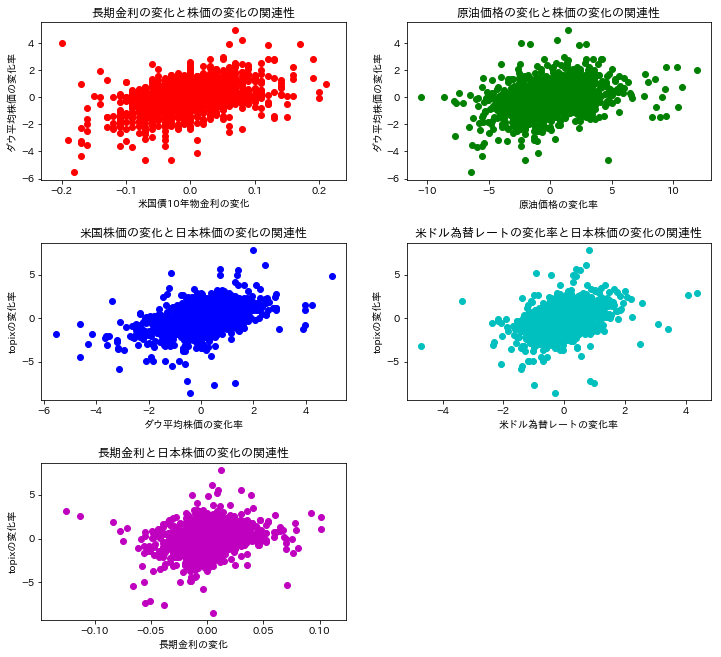

In [31]:
##マーケットデータの関係性を可視化
fig = plt.figure(figsize=(12.0, 11.0))
plt.subplots_adjust(wspace=0.2, hspace=0.4)   #余白を設定
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
ax = fig.add_subplot(3, 2, 1)
plt.scatter(market_df["us_diff"], market_df["dj_diff"], color=colorlist[0])
plt.title("長期金利の変化と株価の変化の関連性")
plt.xlabel("米国債10年物金利の変化")
plt.ylabel("ダウ平均株価の変化率")

ax = fig.add_subplot(3, 2, 2)
plt.scatter(market_df["wti_diff"], market_df["dj_diff"], color=colorlist[1])
plt.title("原油価格の変化と株価の変化の関連性")
plt.xlabel("原油価格の変化率")
plt.ylabel("ダウ平均株価の変化率")

ax = fig.add_subplot(3, 2, 3)
plt.scatter(market_df["dj_diff"], market_df["ETF_diff"], color=colorlist[2])
plt.title("米国株価の変化と日本株価の変化の関連性")
plt.xlabel("ダウ平均株価の変化率")
plt.ylabel("topixの変化率")

ax = fig.add_subplot(3, 2, 4)
plt.scatter(market_df["USD_diff"], market_df["ETF_diff"], color=colorlist[3])
plt.title("米ドル為替レートの変化率と日本株価の変化の関連性")
plt.xlabel("米ドル為替レートの変化率")
plt.ylabel("topixの変化率")

ax = fig.add_subplot(3, 2, 5)
plt.scatter(market_df["jp_diff"], market_df["ETF_diff"], color=colorlist[4])
plt.title("長期金利と日本株価の変化の関連性")
plt.xlabel("長期金利の変化")
plt.ylabel("topixの変化率")

In [32]:
####Variable order Tensor Decompositionのパラメータを推定####
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [33]:
##アルゴリズムの設定
k = 10
R = 300
keep = 1
burnin = int(150/keep)
iter = 0
disp = 10
index_uv1 = news_index1[0]
index_uv2 = news_index2[0]
type_n = [item_n-1, element_n-1, trend_n-1]

In [34]:
##オブジェクトごとのインデックスと割当配列を設定
#itemのインデックスと割当配列を設定
item_index = [j for j in range(item_n-1)]
item_list = [j for j in range(item_n-1)]
item_freq = np.repeat(0, item_n-1)
item_dt0 = item_dt[index_uv1, ]

print("itemのインデックスを作成します。")
for j in range(item_n-1):
    tmp_index = np.where(item_dt0==j)
    index1 = index_uv1[tmp_index[0]]
    index2 = np.array(tmp_index[1], dtype="int")
    m = index1.shape[0]
    item_index[j] = np.unique(index1)
    item_freq[j] = item_index[j].shape[0]
    index_row = np.array(scipy.stats.rankdata(index1, method="dense"), dtype="int")
    item_list[j] = np.array(sparse.coo_matrix((np.repeat(1, m), (index_row-1, index2)), 
                                              shape=(item_freq[j], max_col)).todense(), dtype="int8")
    
#elementのインデックスと割当配列を設定
element_index = [j for j in range(element_n-1)]
element_list = [j for j in range(element_n-1)]
element_freq = np.repeat(0, element_n-1)
element_dt0 = element_dt[index_uv1, ]
print("elementのインデックスを作成します。")

for j in range(element_n-1):
    tmp_index = np.where(element_dt0==j)
    index1 = index_uv1[tmp_index[0]]
    index2 = np.array(tmp_index[1], dtype="int")
    m = index1.shape[0]
    element_index[j] = np.unique(index1)
    element_freq[j] = element_index[j].shape[0]
    index_row = np.array(scipy.stats.rankdata(index1, method="dense"), dtype="int")
    element_list[j] = np.array(sparse.coo_matrix((np.repeat(1, m), (index_row-1, index2)), 
                                                 shape=(element_freq[j], max_col)).todense(), dtype="int8")
    
#trendのインデックスと割当配列を設定
trend_index = [j for j in range(trend_n-1)]
trend_list = [j for j in range(trend_n-1)]
trend_freq = np.repeat(0, trend_n-1)
trend_dt0 = trend_dt[index_uv1, ]
print("trendのインデックスを作成します。")

for j in range(trend_n-1):
    tmp_index = np.where(trend_dt0==j)
    index1 = index_uv1[tmp_index[0]]
    index2 = np.array(tmp_index[1], dtype="int")
    m = index1.shape[0]
    trend_index[j] = np.unique(index1)
    trend_freq[j] = trend_index[j].shape[0]
    index_row = np.array(scipy.stats.rankdata(index1, method="dense"), dtype="int")
    trend_list[j] = np.array(sparse.coo_matrix((np.repeat(1, m), (index_row-1, index2)), 
                                              shape=(trend_freq[j], max_col)).todense(), dtype="int8")
    
#要因有無のflagを設定
Z = np.array((item_dt!=item_n-1) & (element_dt!=element_n-1) & (trend_dt!=trend_n-1), dtype="int8")
    
#リストに格納
object_freq = [item_freq, element_freq, trend_freq]
object_index = [item_index, element_index, trend_index]
object_list = [item_list, element_list, trend_list]
del item_freq, element_freq, trend_freq
del item_index, element_index, trend_index
del item_list, element_list, trend_list

itemのインデックスを作成します。
elementのインデックスを作成します。
trendのインデックスを作成します。


In [35]:
##データの設定
#入力変数の設定
market_df_all = pd.merge(target_date[["date"]], market_df, on="date", how="left")
market_df1 = pd.merge(target_date1[["date"]], market_df, on="date", how="left")
market_df2 = pd.merge(target_date2[["date"]], market_df, on="date", how="left")
print([market_df1.shape[0], target_date1.shape[0], np.sum(pd.isna(market_df1["ETF_price"]))])   
print([market_df2.shape[0], target_date2.shape[0], np.sum(pd.isna(market_df2["ETF_price"]))])
x1 = np.array(market_df1[["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", "ETF_diff", "wti_diff"]])
x2 = np.array(market_df2[["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", "ETF_diff", "wti_diff"]])
x1 = np.array(np.hstack((np.repeat(1, N1)[:, np.newaxis], x1)), dtype="float32")
x2 = np.array(np.hstack((np.repeat(1, N2)[:, np.newaxis], x2)), dtype="float32")
x_col = x1.shape[1]
k_vec = np.repeat(1, k)
x_vec = np.repeat(1, x_col)
m_vec = np.repeat(1.0, max_col)

#応答変数の設定
y = np.array(target_panel["diff_ratio"] * 100)
y1 = np.array(target_panel1["diff_ratio"] * 100)
y2 = np.array(target_panel2["diff_ratio"] * 100)

#企業一覧
company = pd.unique(target_panel["銘柄名"])

[854578, 854578, 0]
[213645, 213645, 0]


In [36]:
##株価とマーケット指標との関連
#相関をチェック
i = 101
print(company[i])
temp_df = pd.concat([target_panel[["コード", "銘柄名", "業種", "diff_ratio"]], 
                     market_df_all[["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", 
                                    "ETF_diff", "wti_diff"]]], axis=1)
index = np.where(temp_df["銘柄名"]==company[i])[0]
temp_df.iloc[index][["diff_ratio", "USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", 
                     "ETF_diff", "wti_diff"]].corr()

日本ゼオン


,diff_ratio,USD_diff,EUR_diff,ff_diff,us_diff,call_diff,jp_diff,dj_diff,ETF_diff,wti_diff
diff_ratio,1.000000,0.251547,0.250602,-0.033813,0.152364,-0.021364,0.173715,0.296447,0.642366,0.113676
USD_diff,0.251547,1.000000,0.615333,-0.011164,0.414700,0.019184,0.227405,0.270953,0.379117,0.063787
EUR_diff,0.250602,0.615333,1.000000,-0.023540,0.373580,-0.003558,0.234592,0.392096,0.372904,0.193516
ff_diff,-0.033813,-0.011164,-0.023540,1.000000,0.019828,-0.081619,0.020944,-0.029041,-0.031090,-0.067278
us_diff,0.152364,0.414700,0.373580,0.019828,1.000000,0.029617,0.348288,0.433786,0.266806,0.241291
call_diff,-0.021364,0.019184,-0.003558,-0.081619,0.029617,1.000000,-0.009464,0.006633,-0.003066,-0.012159
jp_diff,0.173715,0.227405,0.234592,0.020944,0.348288,-0.009464,1.000000,0.121982,0.272070,0.040736
dj_diff,0.296447,0.270953,0.392096,-0.029041,0.433786,0.006633,0.121982,1.000000,0.454792,0.324256
ETF_diff,0.642366,0.379117,0.372904,-0.031090,0.266806,-0.003066,0.272070,0.454792,1.000000,0.177061
wti_diff,0.113676,0.063787,0.193516,-0.067278,0.241291,-0.012159,0.040736,0.324256,0.177061,1.000000


Text(0, 0.5, '株価の変化率')

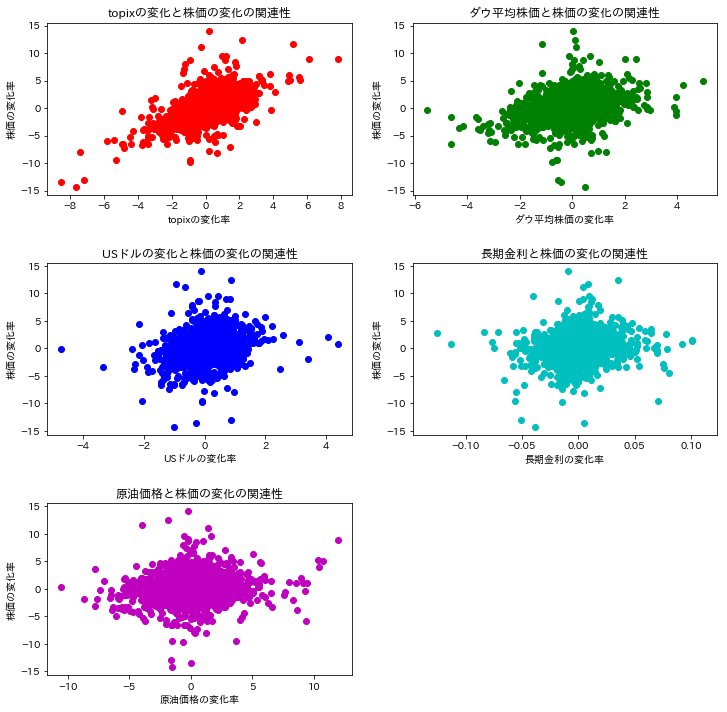

In [37]:
#散布図をチェック
fig = plt.figure(figsize=(12.0, 12.0))
plt.subplots_adjust(wspace=0.2, hspace=0.4)   #余白を設定
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
ax = fig.add_subplot(3, 2, 1)
plt.scatter(market_df_all.iloc[index]["ETF_diff"], y[index], color=colorlist[0])
plt.title("topixの変化と株価の変化の関連性")
plt.xlabel("topixの変化率")
plt.ylabel("株価の変化率")

ax = fig.add_subplot(3, 2, 2)
plt.scatter(market_df_all.iloc[index]["dj_diff"], y[index], color=colorlist[1])
plt.title("ダウ平均株価と株価の変化の関連性")
plt.xlabel("ダウ平均株価の変化率")
plt.ylabel("株価の変化率")

ax = fig.add_subplot(3, 2, 3)
plt.scatter(market_df_all.iloc[index]["USD_diff"], y[index], color=colorlist[2])
plt.title("USドルの変化と株価の変化の関連性")
plt.xlabel("USドルの変化率")
plt.ylabel("株価の変化率")

ax = fig.add_subplot(3, 2, 4)
plt.scatter(market_df_all.iloc[index]["jp_diff"], y[index], color=colorlist[3])
plt.title("長期金利と株価の変化の関連性")
plt.xlabel("長期金利の変化率")
plt.ylabel("株価の変化率")

ax = fig.add_subplot(3, 2, 5)
plt.scatter(market_df_all.iloc[index]["wti_diff"], y[index], color=colorlist[4])
plt.title("原油価格と株価の変化の関連性")
plt.xlabel("原油価格の変化率")
plt.ylabel("株価の変化率")

In [38]:
##事前分布の設定
#階層モデルの事前分布
delta1 = np.repeat(0, x_col)
delta2 = np.repeat(0, k)
nu1 = 1; nu2 = 1
V1 = 0.1 * np.diag(np.ones(x_col))
V2 = 0.1 * np.diag(np.ones(k))
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
alpha_t = np.repeat(0.0, k)
Cov_t = np.diag(np.repeat(100, k))
inv_Cov_t = np.linalg.inv(Cov_t)
tau = 100 
s02 = 1.0
v02 = 1.0

In [39]:
##パラメータの初期値
#階層モデルの初期値
alpha = np.repeat(0.0, x_col)
alpha_u = np.repeat(0.0, k)
alpha_i = np.repeat(0.0, k)
alpha_e = np.repeat(0.0, k)
Cov = np.diag(np.repeat(1.0, x_col))
Cov_u = np.diag(np.repeat(0.25, k))
Cov_i = np.diag(np.repeat(0.3, k))
Cov_e = np.diag(np.repeat(0.3, k))
inv_Cov = np.linalg.inv(Cov)
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_i = np.linalg.inv(Cov_i)
inv_Cov_e = np.linalg.inv(Cov_e)

#モデルパラメータの初期値
beta = np.array(np.mean(y1), dtype="float32")
theta = np.array(np.random.multivariate_normal(alpha, np.diag(np.repeat(0.01, x_col)), n), dtype="float32")
theta_u = np.array(np.random.multivariate_normal(alpha_u, np.diag(np.repeat(0.01, k)), n), dtype="float32")
theta_i = np.array(np.vstack((np.random.multivariate_normal(alpha_i, np.diag(np.repeat(0.01, k)), item_n-1), 
                              np.repeat(1, k))), dtype="float32")
theta_e = np.array(np.vstack((np.random.multivariate_normal(alpha_e, np.diag(np.repeat(0.01, k)), element_n-1),
                              np.repeat(1, k))), dtype="float32")
theta_t = np.array(np.vstack((np.random.multivariate_normal(alpha_t, np.diag(np.repeat(0.01, k)), trend_n-1), 
                              np.repeat(1, k))), dtype="float32")
Sigma = np.sqrt(np.sum(np.power(y1 - beta, 2)) / N1)

#期待値の初期値
theta_vec = theta[company_id1, ]
theta_company = theta_u[company_id1, ]
joint_theta = np.zeros((N1, k), dtype="float32")
uv = np.repeat(0.0, N1)
for i in range(max_col):
    index = news_index1[i]
    joint_theta[index, ] += theta_i[item_id1[i], ] * theta_e[element_id1[i], ] * theta_t[trend_id1[i], ]
theta_mu = np.sum(x1 * theta_vec, axis=1)
uv[index_uv1] = np.dot(theta_u[company_id1[index_uv1], ] * joint_theta[index_uv1, ], k_vec)
mu = beta + theta_mu + uv

In [40]:
##パラメータの格納用配列
BETA = np.array(np.repeat(0, int(R/keep)), dtype="float32")
THETA = np.zeros((n, x_col, int(R/keep)), dtype="float32")
THETA_U = np.zeros((n, k, int(R/keep)), dtype="float32")
THETA_I = np.zeros((item_n, k, int(R/keep)), dtype="float32")
THETA_E = np.zeros((element_n, k, int(R/keep)), dtype="float32")
THETA_T = np.zeros((trend_n, k, int(R/keep)), dtype="float32")

In [41]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.norm.logpdf(y1, np.mean(y1), np.std(y1)))
print(LLst)

#初期値の対数尤度
LL = np.sum(scipy.stats.norm.logpdf(y1, mu, Sigma))
print(LL)

-1872477.6108569673
-1878364.4583597253


In [65]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##モデル期待値をサンプリング
    #モデル誤差を定義
    Sigma_sq = np.power(Sigma, 2)
    er_y = y1 - theta_mu - uv

    #正規分布から期待値をサンプリング
    weights = np.power(tau, 2) / (Sigma_sq/N1 + np.power(tau, 2))
    mu_par = weights * np.mean(er_y)
    beta = np.random.normal(mu_par, weights*Sigma_sq/N1, 1)

    #逆ガンマ分布から標準偏差をサンプリング
    er_y = y1 - beta - theta_mu - uv
    s1 = np.sum(np.power(er_y, 2)) + s01
    s2 = N1 + s02
    Sigma = np.sqrt(1/np.random.gamma(s2/2, 1/(s1/2), 1))
    Sigma_sq = np.power(Sigma, 2)

    ##企業の回帰ベクトルと特徴ベクトルをサンプリング
    #モデル誤差を定義
    er_y = y1 - beta 
    inv_Cov0 = np.diag(np.append(np.diag(inv_Cov), np.diag(inv_Cov_u)))

    for i in range(n):
        #事後分布のパラメータ
        index = company_index1[i]    
        x11 = np.hstack((x1[index, ], joint_theta[index, ])); y11 = er_y[index]
        xy = np.dot(x11.T, y11)
        xxv = np.dot(x11.T, x11) + inv_Cov0
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov0, np.append(alpha, alpha_u)))

        #多変量正規分布からパラメータをサンプリング
        theta_temp = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1).reshape(-1)
        theta[i, ] = theta_temp[np.arange(x_col)]
        theta_u[i, ] = theta_temp[x_col+np.arange(k)]

    #データの更新
    theta_vec = theta[company_id1, ]
    theta_mu = np.sum(x1 * theta_vec, axis=1)
    theta_company = theta_u[company_id1, ]


    ##オブジェクトごとの特徴ベクトルをサンプリング
    #パラメータをリストに格納
    er_y = y1 - beta - theta_mu
    theta_list = [theta_i, theta_e, theta_t]
    inv_Cov_f = [inv_Cov_i, inv_Cov_e, inv_Cov_t]

    for i in range(len(type_n)):
        m = object_freq[i]
        g_index = object_index[i]
        g_list = object_list[i]
        theta_tmp = np.zeros((type_n[i], k), dtype="float32")

        for j1 in range(type_n[i]):
            #データの設定
            except_dt = np.zeros((m[j1], max_col))
            x = np.zeros((m[j1], k), dtype="float32")
            index = g_index[j1]; z = g_list[j1]

            #オブジェクトのインデックスを抽出
            index1 = item_dt[index, ]
            index2 = element_dt[index, ]
            index3 = trend_dt[index, ]
            z_target = Z[index, ]

            #推定対象のパラメータを除去
            theta_fixed = theta_company[index, ]
            for j2 in range(max_col):
                tmp_dt = theta_i[index1[:, j2], ] * theta_e[index2[:, j2], ] * theta_t[index3[:, j2], ] * z_target[:, j2][:, np.newaxis]
                except_dt[:, j2] = np.dot(tmp_dt * theta_fixed, k_vec)
                x += z[:, j2][:, np.newaxis] * tmp_dt
            except_dt = np.dot((1-z) * except_dt, m_vec)
            x = x / theta_list[i][j1, ] * theta_fixed
            
            #事後分布のパラメータ
            target_y = er_y[index] - except_dt
            xy = np.dot(x.T, target_y)
            xxv = np.dot(x.T, x) + inv_Cov_f[i]
            inv_xxv = np.linalg.inv(xxv)
            theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_f[i], alpha))

            #多変量正規分布から事後分布をサンプリング
            if i==0:
                theta_i[j1, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            elif i==1:
                theta_e[j1, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            else:
                theta_t[j1, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)

        #リストに変換
        theta_list = [theta_i, theta_e, theta_t]

    #期待値を更新
    uv = np.repeat(0.0, N1)
    for i in range(max_col):
        index = news_index1[i]
        joint_theta[index, ] += theta_i[item_id1[i], ] * theta_e[element_id1[i], ] * theta_t[trend_id1[i], ]
    theta_mu = np.sum(x1 * theta_vec, axis=1)
    uv[index_uv1] = np.dot(theta_company[index_uv1, ] * joint_theta[index_uv1, ], k_vec)
    mu = beta + theta_mu + uv


    ##階層モデルのパラメータをサンプリング
    #回帰ベクトルの階層モデルの分散共分散行列をサンプリング
    er = theta - np.mean(theta, axis=0)
    IW_R = np.dot(er.T, er) + V1
    Sn = n + nu1
    Cov = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov = np.linalg.inv(Cov)

    #企業特徴ベクトルの階層モデルの分散共分散行列をサンプリング
    #er = theta_u - np.mean(theta_u, axis=0)
    #IW_R = np.dot(er.T, er) + V2
    #Sn = n + nu1
    #Cov_u = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    #inv_Cov_u = np.linalg.inv(Cov_u)
    
    
    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        BETA[mkeep] = beta
        THETA[:, :, mkeep] = theta
        THETA_U[:, :, mkeep] = theta_u
        THETA_I[:, :, mkeep] = theta_i
        THETA_E[:, :, mkeep] = theta_e
        THETA_T[:, :, mkeep] = theta_t
    
    if rp%disp==0:
        #学習データに対するRMSE
        RMSE = np.sqrt(np.sum(np.power(y1 - mu, 2)) / N1)

        #テストデータに対するRMSE
        joint_theta0 = np.zeros((N2, k), dtype="float32")
        uv0 = np.repeat(0.0, N2)
        for i in range(max_col):
            index = news_index2[i]
            joint_theta0[index, ] += theta_i[item_id2[i], ] * theta_e[element_id2[i], ] * theta_t[trend_id2[i], ]
        uv0[index_uv2] = np.dot(theta_u[company_id2[index_uv2], ] * joint_theta0[index_uv2, ], k_vec)
        mu0 = beta + np.sum(x2 * theta[company_id2, ], axis=1) + uv0
        RMSE0 = np.sqrt(np.sum(np.power(y2 - mu0, 2)) / N2)
        print([rp, RMSE, RMSE0])

KeyboardInterrupt: 

In [43]:
##結果の確認と業績インパクトを算出
#パラメータの事後平均
RS = np.arange(20, rp)
theta_u = np.mean(THETA_U[:, :, RS], axis=2)
theta_i = np.mean(THETA_I[:, :, RS], axis=2)
theta_e = np.mean(THETA_E[:, :, RS], axis=2)
theta_t = np.mean(THETA_T[:, :, RS], axis=2)

In [64]:
THETA_U[:, :, 120]

array([[-8.3377636e-06,  1.1603560e-06,  5.2463292e-06, ...,
         4.1699832e-06,  2.1802191e-06, -2.1859169e-06],
       [-1.8695771e-06, -7.2881217e-06,  4.5278230e-06, ...,
         5.2626051e-06,  1.5968229e-06, -3.6508895e-06],
       [ 1.2752834e-06,  8.7073590e-07,  1.6142493e-06, ...,
        -8.6127557e-06,  2.9251723e-06,  1.0900218e-06],
       ...,
       [ 2.1988803e-06,  3.0775427e-06, -2.5485069e-06, ...,
        -3.5254850e-06, -3.5652163e-06, -7.6420702e-06],
       [-2.9079372e-06,  2.0775885e-06, -1.8697366e-06, ...,
         1.1783435e-06, -5.9043958e-07,  6.4198239e-06],
       [-2.9913697e-06,  2.2621969e-06, -2.7402491e-06, ...,
         2.3804250e-06,  3.7357972e-07, -6.1003234e-06]], dtype=float32)

In [44]:
#NaNを変換
unique_item["item"].iloc[item_n-1] = ""
unique_element["element"].iloc[element_n-1] = ""
unique_trend["trend"].iloc[trend_n-1] = ""

C:\statistics\anaconda\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [45]:
##推定対象のシナリオを抽出
#要因-企業の直接シナリオを抽出
s1 = scenario1[["f.item", "f.element", "f.trend", "c.name", "c.ticker"]]
s1 = s1.iloc[np.where(s1.duplicated()==False)[0]]
index1 = pd.merge(s1, target_company, left_on="c.ticker", right_on="コード", how="left")["id"]
index2 = pd.merge(s1, unique_item, left_on="f.item", right_on="item", how="left")["id"]
index3 = pd.merge(s1, unique_element, left_on="f.element", right_on="element", how="left")["id"]
index4 = pd.merge(s1, unique_trend, left_on="f.trend", right_on="trend", how="left")["id"]
index = np.where((pd.isna(index1)==False) & (pd.isna(index2)==False) & (pd.isna(index3)==False) & (pd.isna(index4)==False))[0]
s1 = s1.iloc[index]
s1.index = np.arange(s1.shape[0])
s1["company_id"] = np.array(index1[index], dtype="int")
s1["item_id"] = np.array(index2[index], dtype="int")
s1["element_id"] = np.array(index3[index], dtype="int")
s1["trend_id"] = np.array(index4[index], dtype="int")
s1.columns = ["item", "element", "trend", "company", "ticker", "company_id", "item_id", "element_id", "trend_id"]
s1["pattern"] = np.repeat("シナリオ1", s1.shape[0])

#要因-要因-企業の間接シナリオを抽出
s2 = scenario2[["f1.item", "f1.element", "f1.trend", "c.name", "c.ticker"]]
s2 = s2.iloc[np.where(s2.duplicated()==False)[0]]
index1 = pd.merge(s2, target_company, left_on="c.ticker", right_on="コード", how="left")["id"]
index2 = pd.merge(s2, unique_item, left_on="f1.item", right_on="item", how="left")["id"]
index3 = pd.merge(s2, unique_element, left_on="f1.element", right_on="element", how="left")["id"]
index4 = pd.merge(s2, unique_trend, left_on="f1.trend", right_on="trend", how="left")["id"]
index = np.where((pd.isna(index1)==False) & (pd.isna(index2)==False) & (pd.isna(index3)==False) & (pd.isna(index4)==False))[0]
s2 = s2.iloc[index]
s2.index = np.arange(s2.shape[0])
s2["company_id"] = np.array(index1[index], dtype="int")
s2["item_id"] = np.array(index2[index], dtype="int")
s2["element_id"] = np.array(index3[index], dtype="int")
s2["trend_id"] = np.array(index4[index], dtype="int")
s2.columns = ["item", "element", "trend", "company", "ticker", "company_id", "item_id", "element_id", "trend_id"]
s2["pattern"] = np.repeat("シナリオ2", s2.shape[0])

#要因-要因-企業の直接シナリオを抽出
s3 = scenario2[["f2.item", "f2.element", "f2.trend", "c.name", "c.ticker"]]
s3 = s3.iloc[np.where(s3.duplicated()==False)[0]]
index1 = pd.merge(s3, target_company, left_on="c.ticker", right_on="コード", how="left")["id"]
index2 = pd.merge(s3, unique_item, left_on="f2.item", right_on="item", how="left")["id"]
index3 = pd.merge(s3, unique_element, left_on="f2.element", right_on="element", how="left")["id"]
index4 = pd.merge(s3, unique_trend, left_on="f2.trend", right_on="trend", how="left")["id"]
index = np.where((pd.isna(index1)==False) & (pd.isna(index2)==False) & (pd.isna(index3)==False) & (pd.isna(index4)==False))[0]
s3 = s3.iloc[index]
s3.index = np.arange(s3.shape[0])
s3["company_id"] = np.array(index1[index], dtype="int")
s3["item_id"] = np.array(index2[index], dtype="int")
s3["element_id"] = np.array(index3[index], dtype="int")
s3["trend_id"] = np.array(index4[index], dtype="int")
s3.columns = ["item", "element", "trend", "company", "ticker", "company_id", "item_id", "element_id", "trend_id"]
s3["pattern"] = np.repeat("シナリオ3", s3.shape[0])

#シナリオを結合
scenario = pd.concat((s1, s2, s3), axis=0)
scenario.index = np.arange(scenario.shape[0])

In [46]:
scenario["score"] = np.sum(theta_u[scenario["company_id"], ] * theta_i[scenario["item_id"], ] * 
                           theta_e[scenario["element_id"], ] * theta_t[scenario["trend_id"], ], axis=1)

In [47]:
scenario

,item,element,trend,company,ticker,company_id,item_id,element_id,trend_id,pattern,score
0,スイッチ,需要,lesser,日本電産,6594,126,290,3,0,シナリオ1,-9.094803e-07
1,FA機器,需要,lesser,日本電産,6594,126,292,3,0,シナリオ1,-1.624076e-06
2,計測機器,需要,lesser,日本電産,6594,126,438,3,0,シナリオ1,-2.871672e-06
3,FA機器,需要,,日本電産,6594,126,292,3,2,シナリオ1,1.609981e-07
4,プラグ,需要,greater,日特殊陶,5334,220,507,3,1,シナリオ1,5.228059e-07
5,自動車エンジン部品,需要,,日特殊陶,5334,220,283,3,2,シナリオ1,-4.681567e-07
6,電子部品,需要,greater,日特殊陶,5334,220,78,3,1,シナリオ1,-5.097596e-07
7,電子部品,需要,,日特殊陶,5334,220,78,3,2,シナリオ1,-1.443913e-06
8,プラグ,需要,,日特殊陶,5334,220,507,3,2,シナリオ1,1.260834e-06
9,エクステリア,需要,,ＬＩＸＩＬグループ,5938,163,294,3,2,シナリオ1,-1.976691e-06


In [49]:
uv[index_uv1]

array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
uv1

NameError: name 'uv1' is not defined

In [51]:
index_uv1

array([     0,      4,      5, ..., 854566, 854567, 854576])